# Benchmarking

In [44]:
a = rand(10^7);

In [45]:
# Sum
sum(a)

5.00092850371994e6

In [46]:
# Benchmarking using @time can be noisy
@time sum(a)
@time sum(a)
@time sum(a)

  0.006576 seconds (1 allocation: 16 bytes)
  0.006241 seconds (1 allocation: 16 bytes)
  0.005174 seconds (1 allocation: 16 bytes)


5.00092850371994e6

# Benchmark Tools Package

In [47]:
using Pkg
#Pkg.add("BenchmarkTools");

In [48]:
using BenchmarkTools

# 1. The C Language

In [49]:
#Pkg.add("Libdl")

In [50]:
using Libdl

C_code = """
#include <stddef.h>
double c_sum(size_t n, double *x){
    double s = 0.0;
    for (size_t i = 0; i < n; ++i){
        s += x[i];
    }
    return s;
}
"""

const Clib = tempname()

# compile (Only works if gcc is installed)
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`,"w") do f
    print(f, C_code)
end

# Julia function that calls C_code
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}),length(X), X)


c_sum (generic function with 1 method)

In [51]:
c_sum(a)

5.000928503720694e6

In [52]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 378 samples with 1 evaluation.
 Range (min … max):  12.300 ms …  16.928 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.269 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.223 ms ± 489.192 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                          ▁▃██▃▄▁                               
  ▂▂▃▅▆▃▆▇▆▆▃▅▃▄▃▂▂▃▂▄▃▅▄▆███████▇▇▅▇▄▄▃▄▂▁▄▄▃▃▃▂▂▂▁▃▁▂▂▁▁▁▂▁▂ ▃
  12.3 ms         Histogram: frequency by time         14.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [53]:
println("C: Fastest time was $(minimum(c_bench.times)/ 1e6) msec")

C: Fastest time was 12.3002 msec


In [54]:
d = Dict()

Dict{Any, Any}()

In [55]:

d["C"] = minimum(c_bench.times)/1e6

12.3002

In [56]:
using Plots
gr()

Plots.GRBackend()

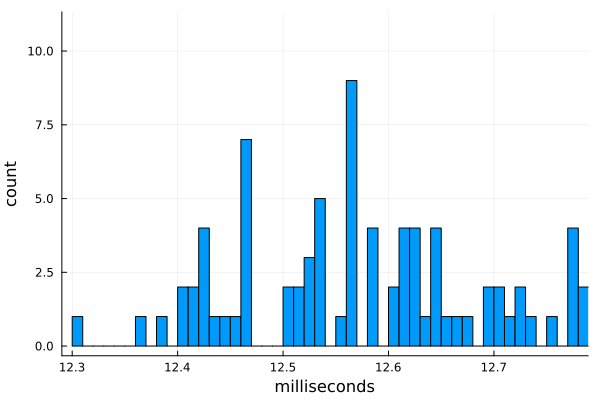

In [57]:
using Statistics
t = c_bench.times/1e6
m, STD = minimum(t), std(t)

histogram(t, bins=500, xlim=(m-0.01, m+STD), xlabel="milliseconds",ylabel="count",label="")

# 2. C with -ffast-math

In [58]:
const Clib_fastmath = tempname()

# compile using fast math (Only works if gcc is installed)
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`,"w") do f
    print(f, C_code)
end

# Julia function that calls C_code
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}),length(X), X)


c_sum_fastmath (generic function with 1 method)

In [59]:
c_sum_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 735 samples with 1 evaluation.
 Range (min … max):  6.199 ms …  11.138 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.602 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.796 ms ± 437.723 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁▆█▄▂                                                   
  ▃▁▂▃▅█████▇▄▄▄▄▃▄▃▃▃▃▂▄▄▆▇▅█▆▆▆▅▄▃▄▃▂▃▃▃▃▂▂▁▂▂▂▂▂▁▂▂▁▂▂▁▁▂▂ ▃
  6.2 ms          Histogram: frequency by time        8.14 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [60]:
d["C -ffast-math"] = minimum(c_sum_fastmath_bench.times)/1e6

6.1989

# 3. Python's Built in Sum

In [61]:
using PyCall

In [62]:
# get python function
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [63]:
pysum(a)

5.000928503720694e6

In [64]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  631.532 ms … 654.408 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     633.655 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   638.883 ms ±   9.485 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▁ ▁█             ▁                                     ▁  ▁  
  █▁█▁██▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  632 ms           Histogram: frequency by time          654 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [65]:
d["Python built-in"] = minimum(py_list_bench.times)/1e6

631.5319

# 4. Python: numpy

In [66]:
#Pkg.add("Conda")
using Conda

In [67]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 389 samples with 1 evaluation.
 Range (min … max):  12.211 ms …  18.680 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.785 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.841 ms ± 601.522 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁▅▃▆█▆▁                                                
  ▃▅▆▇▇█▇███████▆▆▄▃▁▂▁▃▁▁▁▃▂▂▃▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▂ ▃
  12.2 ms         Histogram: frequency by time         15.5 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [68]:
d["Python numpy"] = minimum(py_numpy_bench.times)/1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.3002
  "Python numpy"    => 12.2115
  "Python built-in" => 631.532
  "C -ffast-math"   => 6.1989

# 5. Python, hand-written

In [69]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s 
"""
sum_py = py"py_sum"

PyObject <function py_sum at 0x0000023DEB9579A0>

In [70]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  843.292 ms …   1.061 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     948.632 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   952.147 ms ± 89.529 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █      █                        █          █      █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  843 ms          Histogram: frequency by time          1.06 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [71]:
d["Python hand-written"] = minimum(py_hand.times)/1e6

843.2921

# 6. Julia (Built-in)

In [72]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [73]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 937 samples with 1 evaluation.
 Range (min … max):  4.506 ms …   9.700 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.230 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.324 ms ± 327.833 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                       ▁▄▆▇█▄▁▂             ▁                  
  ▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▆█████████▇▅▃▄▃▄▄▆▇▇▆██▇▅▅▄▄▃▃▃▁▂▁▂▁▂▂▂ ▄
  4.51 ms         Histogram: frequency by time        6.06 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [74]:
d["Julia built-in"] = minimum(j_bench.times)/1e6

4.5057

# 7. Julia (hand-written)

In [75]:
function mysum(A)
    s = 0.0
    for a in A
        s += a 
    end
    s
end

mysum (generic function with 1 method)

In [76]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 371 samples with 1 evaluation.
 Range (min … max):  12.572 ms …  15.911 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.553 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.484 ms ± 433.717 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                          ▃█▅▆▄▂                                
  ▂▂▄▄▆▆▄▆▅▄▃▅▃▃▃▂▁▃▂▃▄▃▄▅███████▅▅▄▃▃▄▃▃▃▃▃▃▃▁▂▂▃▃▁▁▁▁▁▁▂▁▁▁▂ ▃
  12.6 ms         Histogram: frequency by time         14.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [77]:
d["Julia hand-written"] = minimum(j_bench_hand.times)/1e6

12.5716

# 8. Julia (hand-written w. simd)

In [78]:
function mysum_simd(A)
    s = 0.0
    @simd for a in A
        s += a 
    end
    s
end

mysum_simd (generic function with 1 method)

In [79]:
j_bench_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 845 samples with 1 evaluation.
 Range (min … max):  4.323 ms …   8.448 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.756 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.900 ms ± 586.793 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                      ▅█▃ ▁▁                                   
  ▂▂▂▂▂▃▂▂▁▂▂▂▁▂▃▃▃▄▅▇██████▇▇▅▅▄▃▃▃▃▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▁▁▂ ▃
  4.32 ms         Histogram: frequency by time         7.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [80]:
d["Julia hand-written simd"] = minimum(j_bench_simd.times)/1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.3231
  "C"                       => 12.3002
  "Python numpy"            => 12.2115
  "Julia hand-written"      => 12.5716
  "Python hand-written"     => 843.292
  "Python built-in"         => 631.532
  "Julia built-in"          => 4.5057
  "C -ffast-math"           => 6.1989

# Summary

In [81]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....4.3
Julia built-in..............4.5
C -ffast-math...............6.2
Python numpy...............12.2
C..........................12.3
Julia hand-written.........12.6
Python built-in...........631.5
Python hand-written.......843.3
